In [1]:
!pip install transformers

In [2]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import BertConfig
from transformers import AdamW as TransformersAdamW
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import accuracy_score, classification_report

In [3]:
class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [4]:
# Load the CSV file into a DataFrame
file_path = 'https://raw.githubusercontent.com/Letieateat/Sentiment-Analysis-on-Traditional-Chinese-Lyrics/main/dataset/final_sentiments.csv'
df = pd.read_csv(file_path)

# Select only the three specific columns
df = df[['final_lyrics', 'human_2']]

In [5]:
label_map =  {'Negative': 0, 'Positive': 1}
df['labels'] = df['human_2'].map(label_map)
df.rename(columns={'final_lyrics': 'Input'}, inplace=True)

In [6]:
# Load model & tokenizer
tokenizer = BertTokenizerFast.from_pretrained('ckiplab/bert-base-chinese')
#config = BertConfig.from_pretrained('ckiplab/bert-base-chinese', num_labels=len(label_map), hidden_dropout_prob=0.3)
config = BertConfig.from_pretrained('ckiplab/bert-base-chinese', num_labels=len(label_map), hidden_dropout_prob=0.0, attention_probs_dropout_prob=0.0)
model = BertForSequenceClassification.from_pretrained('ckiplab/bert-base-chinese', config=config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/409M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Check the availability of GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [8]:
# Prepare datasets
train, temp = train_test_split(df, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

train_dataset = LyricsDataset(train['Input'].tolist(), train['labels'].tolist(), tokenizer)
val_dataset = LyricsDataset(val['Input'].tolist(), val['labels'].tolist(), tokenizer)
test_dataset = LyricsDataset(test['Input'].tolist(), test['labels'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [9]:
# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [10]:
# Training

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_model_path = 'best_model.pth'
best_val_accuracy = 0
best_val_loss = float('inf')
early_stopping_counter = 0
early_stopping_patience = 3

for epoch in range(10):
    model.train()
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        correct_train_predictions += (predictions == batch['labels']).sum().item()
        total_train_samples += len(batch['labels'])

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train_predictions / total_train_samples
    train_accuracies.append(train_accuracy)

    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            total_val_loss += loss.item()
            total_val_accuracy += (predictions == batch['labels']).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {avg_val_loss}, Val Accuracy: {avg_val_accuracy}')

    # Early stopping
    if avg_val_loss < best_val_loss or avg_val_accuracy > best_val_accuracy:
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            torch.save(model.state_dict(), best_model_path)  # save the model
            print(f'Saved new best model based on accuracy: Accuracy = {best_val_accuracy}')
        early_stopping_counter = 0  # reset the counter
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered!")
            break

# Load the best model for testing or further usage
model.load_state_dict(torch.load(best_model_path))
model.to(device)


Epoch 1, Train Loss: 0.6395960504358466, Train Accuracy: 0.637660485021398, Val Loss: 0.4766875088214874, Val Accuracy: 0.8333333333333334
Saved new best model based on accuracy: Accuracy = 0.8333333333333334
Epoch 2, Train Loss: 0.46887680752710864, Train Accuracy: 0.7988587731811697, Val Loss: 0.4471153259277344, Val Accuracy: 0.7733333333333333
Epoch 3, Train Loss: 0.22164902607487005, Train Accuracy: 0.9215406562054208, Val Loss: 0.41275087743997574, Val Accuracy: 0.7866666666666666
Epoch 4, Train Loss: 0.058281401585025545, Train Accuracy: 0.9900142653352354, Val Loss: 0.4948030460625887, Val Accuracy: 0.8266666666666667
Epoch 5, Train Loss: 0.008454823273826729, Train Accuracy: 1.0, Val Loss: 0.5950967133045196, Val Accuracy: 0.8133333333333334
Epoch 6, Train Loss: 0.033737116821364245, Train Accuracy: 0.9871611982881597, Val Loss: 0.6070940140634775, Val Accuracy: 0.8066666666666666
Early stopping triggered!


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [11]:
# Testing
model.load_state_dict(torch.load(best_model_path))
model.to(device)

model.eval()
total_test_loss = 0
total_test_accuracy = 0
all_true_labels = []
all_predictions = []
incorrect_predictions = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        total_test_loss += loss.item()
        total_test_accuracy += (predictions == batch['labels']).sum().item()

        # Collect all labels and predictions for classification report
        all_true_labels.extend(batch['labels'].cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

        # Capture incorrect predictions
        mismatches = predictions != batch['labels']
        if any(mismatches):
            incorrect_inputs = batch['input_ids'][mismatches]
            incorrect_labels = predictions[mismatches]
            true_labels = batch['labels'][mismatches]
            for input_ids, pred_label, true_label in zip(incorrect_inputs, incorrect_labels, true_labels):
                decoded_input = tokenizer.decode(input_ids, skip_special_tokens=True)
                incorrect_predictions.append({
                    'Lyric': decoded_input,
                    'Predicted Sentiment': list(label_map.keys())[list(label_map.values()).index(pred_label.item())],
                    'Actual Sentiment': list(label_map.keys())[list(label_map.values()).index(true_label.item())]
                })

avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader.dataset)
test_accuracy_score = accuracy_score(all_true_labels, all_predictions)
test_classification_report = classification_report(all_true_labels, all_predictions)

print(f'Test Loss: {avg_test_loss}, Test Accuracy: {avg_test_accuracy}')
print(f'Test Accuracy Score: {test_accuracy_score}')
print(f'Test Classification Report:\n{test_classification_report}')

# Optionally save incorrect predictions to CSV, if any
if incorrect_predictions:
    df_incorrect = pd.DataFrame(incorrect_predictions)
    df_incorrect.to_csv('incorrect_predictions.csv', index=False)
    print(f"Saved {len(incorrect_predictions)} incorrect predictions to 'incorrect_predictions.csv'")
else:
    print("No incorrect predictions to save.")


Test Loss: 0.5434619516134263, Test Accuracy: 0.7947019867549668
Test Accuracy Score: 0.7947019867549668
Test Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86        97
           1       0.87      0.50      0.64        54

    accuracy                           0.79       151
   macro avg       0.82      0.73      0.75       151
weighted avg       0.81      0.79      0.78       151

Saved 31 incorrect predictions to 'incorrect_predictions.csv'


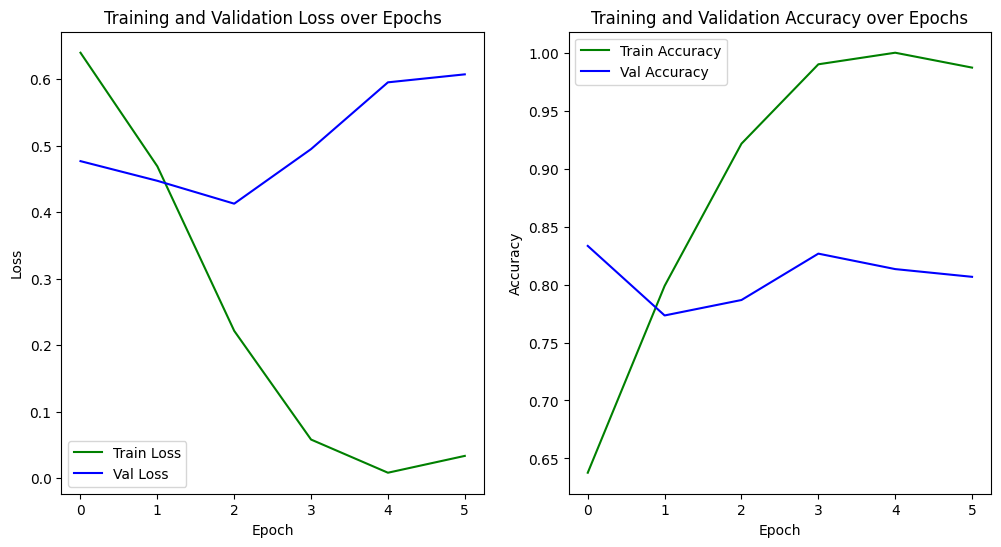

In [12]:
# Plot the loss and accuracy for training and validation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, color='green',label='Train Loss')
plt.plot(val_losses, color='blue',label='Val Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, color='green', label='Train Accuracy')
plt.plot(val_accuracies, color='blue', label='Val Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save the model

In [ ]:
model_save_path = './CKIP_2.bin'

torch.save(model, model_save_path)
torch.save(model.state_dict(), model_save_path)

In [ ]:
drive.mount('/content/drive')
model_save_path = '/content/drive/My Drive/CKIP_2.bin'

# To save the entire model
torch.save(model, model_save_path)

# Alternatively, to save only the state dictionary
torch.save(model.state_dict(), model_save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
